##### Detección de tópicos en ciencia básica: topicos con modelo entrenado

1. Filtrar documentos
2. Aplicar tf-idf
3. Guardar



#### **To do** 
- detectar en inngles
- Documentos repetidos entre repositorios y convocatorias
- mismo proyecto 
-


In [1]:
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize

import heapq
import seaborn as sns

#nltk.download('wordnet')
#nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/danielbustillos/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df_texto_eval = pd.read_csv("./DATA/data_training.csv")
df_texto_eval = df_texto_eval.reset_index(drop=True)
df_texto_eval = df_texto_eval.drop_duplicates(subset=["ID_PROYECTO","NUMERO_CONVOCATORIA","ANIO"], keep="last")
texto = df_texto_eval["DESCRIPCION_PROYECTO"]
df_texto_eval.head(1)

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones


In [5]:
df_texto_eval.columns

Index(['ID_PROYECTO', 'NUMERO_CONVOCATORIA', 'ANIO', 'USUARIO', 'CVU',
       'NOMBRE', 'CVE_RCEA', 'AREA', 'DISCIPLINA', 'SUBDISCIPLINA',
       'INSTITUCION', 'PAIS', 'ESTADO', 'DEPENDENCIA', 'SUBDEPENDENCIA',
       'DESCRIPCION_PROYECTO', 'PALABRAS_CLAVE1', 'PALABRAS_CLAVE2',
       'PALABRAS_CLAVE3'],
      dtype='object')

In [6]:
df_texto_eval["AREA"]

2       CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...
5                                       CIENCIAS SOCIALES
8                                       CIENCIAS SOCIALES
14                 CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA
18                                INGENIERIA Y TECNOLOGIA
                              ...                        
8177               CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA
8180               CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA
8183               CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA
8185               CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA
8187                HUMANIDADES Y CIENCIAS DE LA CONDUCTA
Name: AREA, Length: 2397, dtype: object

#### obtener tfidf
 regresa matriz documentos raices

In [7]:
texto = df_texto_eval["DESCRIPCION_PROYECTO"]

In [8]:
n_features = 512 #number of max words
n_top_words = 30 #words per topic

doc_similarity_thr = 0.15

In [9]:
max_df = .15
min_df = 5

In [10]:
df_texto_eval.shape

(2397, 19)

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df= max_df, min_df=min_df,
                                   max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(texto)

In [20]:
tfidf.todense().shape

(2397, 512)

In [17]:
tfidf.todense()

matrix([[0.04448512, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.02143204],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [12]:
df_texto_eval.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
5,1775,PROBLEMAS-2015-01,2015,X_hgonzalez164212,206295,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos
8,1876,PROBLEMAS-2015-01,2015,X_jarzate122299,122299,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades
14,273,PROBLEMAS-2015-01,2015,X_mvalladares36446,36446,MARIA GUADALUPE VALLADARES CISNEROS,RCEA-02-18283-2009,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,MEDICINA VETERINARIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MORELOS,MEXICO,MORELOS,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,explicacion mexic parasitosis caus principal e...,Mecanismo de accion compuestos secundarios pla...,NaN,NaN
18,857,PROBLEMAS-2015-01,2015,X_mlizardi164087,164087,MANUEL ALEJANDRO LIZARDI JIMENEZ,RCEA-06-26342-2013,INGENIERIA Y TECNOLOGIA,INGENIERIA QUIMICA,NaN,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,MEX,DF,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,identificacion prioritari nacional atend marc ...,Lixiviado,Agua residual,Tratamiento fisicoquimicogalvanico


# 1. Tópicos

Fit the NMF model (generalized Kullback-Leibler divergence)

In [21]:
n_components = 50
n_components # borrar con nuevos docs

50

In [22]:
import time
t0 = time.time()

topic_model = NMF(n_components=round(n_components), random_state=123,
                  beta_loss='kullback-leibler', solver='mu', max_iter=200, alpha=.1,
                  l1_ratio=.5)

topic_model.fit(tfidf)

t1 = time.time()
total = t1-t0
print(total)

15.037659883499146


guardamos el vocabulario de TFIDF

In [23]:
feature_names = tfidf_vectorizer.get_feature_names()

In [24]:
topic_data = []

for topic_idx, topic in enumerate(topic_model.components_):
    index = [i for i in range(len(topic))]
    words = [feature_names[i] for i in index]
    value = [topic[i] for i in index]
    #print(value)
    topic_data.append({"index":index, "words":words, "value":value})


In [25]:
filter_id = "AAA"

df_topicos_nombre = pd.DataFrame([t['words'] for t in topic_data])
df_topicos_nombre.index = [filter_id + str(t).zfill(3) for t in df_topicos_nombre.index]
df_topicos_nombre.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos_nombre.columns]
df_topicos_nombre.iloc[:2,range(20)]

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20
AAA000,abastec,abej,aceit,acomp,acondicion,activity,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agend
AAA001,abastec,abej,aceit,acomp,acondicion,activity,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agend


In [26]:
df_topicos = pd.DataFrame([t['value'] for t in topic_data])
df_topicos.index = [filter_id + str(t).zfill(3) for t in df_topicos.index]
df_topicos.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos.columns]
df_topicos.head(2)

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,...,W503,W504,W505,W506,W507,W508,W509,W510,W511,W512
AAA000,0.000000,0.0,0.018939,0.028879,3.573739e-15,0.008539,0.0,0.0,0.000000e+00,0.000000,...,2.563528e-11,0.000000,2.272108e-15,0.056679,0.0,0.007674,0.0,0.000000e+00,9.050869e-08,0.007974
AAA001,0.130315,0.0,0.010156,0.000000,4.059310e-02,0.000000,0.0,0.0,7.197957e-14,0.128181,...,0.000000e+00,0.062782,0.000000e+00,0.000000,0.0,0.029508,0.0,1.633339e-12,0.000000e+00,0.000000


In [27]:
df_topicos.shape

(50, 512)

# 2.  Top N palabras 

## valor

In [28]:
lista_nlargest = [df_topicos.iloc[topic,:].nlargest(n=50) for topic in range(df_topicos.shape[0])]

In [29]:
df_words = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(50)])
for row in range(df_words.shape[0]):
    df_words.iloc[row,:] = lista_nlargest[row].values

In [30]:
df_words.head()

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,...,word40,word41,word42,word43,word44,word45,word46,word47,word48,word49
0,1.09815,0.853616,0.811919,0.684749,0.6641,0.587603,0.568622,0.550656,0.525568,0.51549,...,0.158368,0.156532,0.155633,0.146327,0.138737,0.133219,0.130758,0.129583,0.123322,0.120765
1,0.955266,0.864576,0.575464,0.573365,0.565966,0.560452,0.51335,0.504093,0.490726,0.483847,...,0.18174,0.172499,0.166315,0.165078,0.164546,0.160831,0.16018,0.152944,0.149205,0.144416
2,0.816422,0.761354,0.722584,0.72235,0.70075,0.628813,0.569321,0.544701,0.507629,0.502816,...,0.138349,0.135755,0.127416,0.118079,0.114877,0.110705,0.1075,0.107017,0.10211,0.101906
3,1.24957,0.687384,0.551421,0.521839,0.519342,0.470038,0.457911,0.443777,0.411034,0.402656,...,0.198166,0.197689,0.195102,0.177829,0.175727,0.16106,0.155269,0.139769,0.133712,0.133699
4,1.17557,1.14565,0.905022,0.819813,0.616047,0.60506,0.587768,0.546299,0.51024,0.433008,...,0.132991,0.129683,0.125355,0.124603,0.120301,0.119858,0.117337,0.116522,0.108047,0.10737


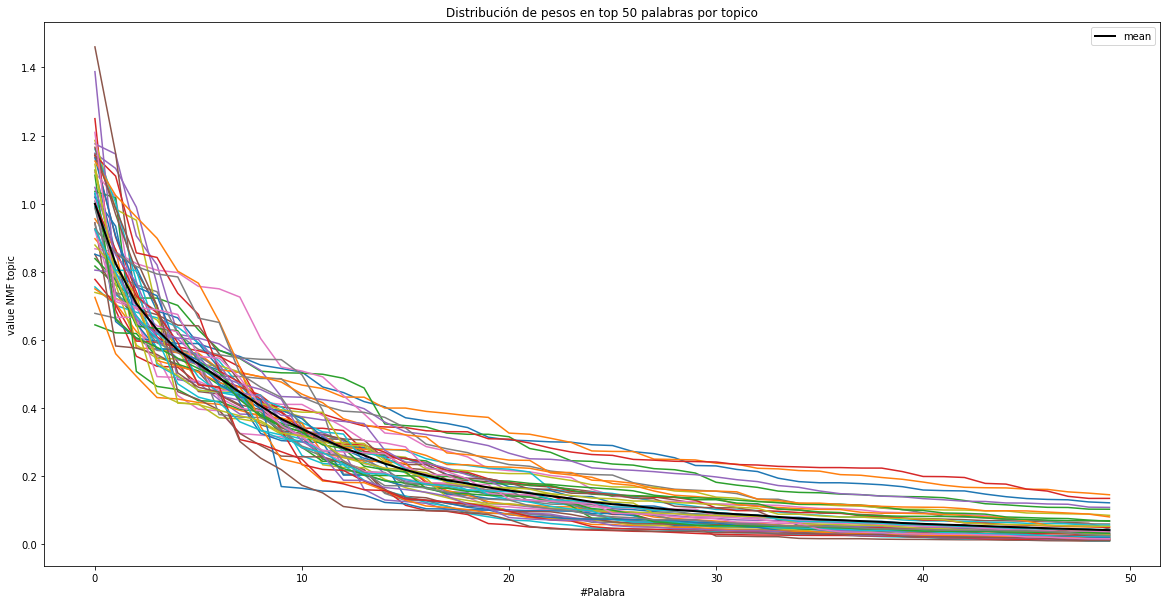

In [31]:
fig = plt.figure(figsize=(20,10))

ax = plt.axes()
numerize = [i for i in range(50)]
for topic in range(df_words.shape[0]):
    x = df_words.iloc[topic,:].values
    ax.plot(numerize,x)
ax.plot(numerize,df_words.mean(axis=0),label="mean",linewidth=2,color="black")
ax.set(xlabel='#Palabra', ylabel='value NMF topic',
       title='Distribución de pesos en top 50 palabras por topico')
ax.legend()
plt.show()


### palabra

In [32]:
df_words_name = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(20)])
for row in range(df_words_name.shape[0]):
    lista_index = df_topicos.iloc[row,:].nlargest(n=20).index.tolist()
    df_words_name.iloc[row,:] = df_topicos_nombre.reset_index(drop=True).loc[row,lista_index].values

In [34]:
df_words_name.head(5)

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12,word13,word14,word15,word16,word17,word18,word19
0,corporal,obes,cardiovascular,hig,mellitus,hormon,ingest,colesterol,hepat,cardiac,insulin,hipertension,sobrepes,sindrom,exclusion,antiinflamatori,elis,arterial,inflamatori,muscul
1,materials,ray,semiconductor,pelicul,nanoestructur,celd,electroquim,ion,oxidacion,combust,solar,precursor,hidrogen,fosil,atom,recubr,por,cristalin,inorgan,petrole
2,atribut,tomador,conflict,comunitari,agend,conceptual,bien,colegi,pobrez,gobi,reserv,epoc,valoracion,gobern,resilient,cient,territorial,paisaj,torn,transit
3,anticuerp,antigen,cells,bioinformat,proliferacion,clinical,genic,pulmon,tumor,tumoral,inmun,purific,sealizacion,quimioterapi,mutacion,amplificacion,fenotip,raton,inhibidor,citotox
4,arquitectur,aprendizaj,conferenc,inteligent,visual,vide,tare,informat,motor,programacion,ciudadan,automat,virtual,trayectori,archiv,neuronal,localizacion,conceptual,robust,codig


# 3. topicos por texto


Asignamos un vectore de topicos para cada texto

In [35]:
lista_topicos = df_topicos.index.tolist()
dataframe_values = pd.DataFrame(columns=lista_topicos, index=[row for row in range(tfidf[:].shape[0])])

In [36]:
topics_results = []
#numero_de_matches = 50
for i_doc in range(tfidf[:].shape[0]):

    valor_topico = [
        np.dot(
            tfidf[i_doc].todense().tolist()[0],
            topic_data[topic_id]["value"]
               ) for topic_id in range(len(topic_data))
                    ] #pesos de topicos
    
    #print([topic["index"] for topic in topic_data])
    #print(i_doc)
    #print(valor_topico)
    #print(np.array([tfidf[i_doc,topic["index"]].sum() for topic in topic_data]) )
    
    #dictionary = valor_topico
    #df de valores unicamente
    dataframe_values.iloc[i_doc,:] = valor_topico

    #appendeamos en el DF:
    #dictionary  = dict(zip(lista_topicos, valor_topico)) # juntar en diccionario palabra-peso
    #df_texto_eval.loc[i_doc,"topic_vector"] = str(dictionary) # si queremos un diccionario
    df_texto_eval.loc[i_doc,"topic_vector"] = str(valor_topico)

In [39]:
dataframe_values.shape

(2397, 50)

In [40]:
df_texto_eval.shape

(4218, 20)

In [41]:
df_texto_eval

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3,topic_vector
2,1105.0,PROBLEMAS-2015-01,2015.0,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones,"[0.02719218315164764, 0.001322431846723916, 0...."
5,1775.0,PROBLEMAS-2015-01,2015.0,X_hgonzalez164212,206295.0,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos,"[0.012549357413581253, 0.8105957174960019, 0.0..."
8,1876.0,PROBLEMAS-2015-01,2015.0,X_jarzate122299,122299.0,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades,"[0.08866689843266312, 0.3489600062805034, 0.04..."
14,273.0,PROBLEMAS-2015-01,2015.0,X_mvalladares36446,36446.0,MARIA GUADALUPE VALLADARES CISNEROS,RCEA-02-18283-2009,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,MEDICINA VETERINARIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MORELOS,MEXICO,MORELOS,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,explicacion mexic parasitosis caus principal e...,Mecanismo de accion compuestos secundarios pla...,NaN,NaN,"[0.09546413333181819, 0.01714447927759952, 0.0..."
18,857.0,PROBLEMAS-2015-01,2015.0,X_mlizardi164087,164087.0,MANUEL ALEJANDRO LIZARDI JIMENEZ,RCEA-06-26342-2013,INGENIERIA Y TECNOLOGIA,INGENIERIA QUIMICA,NaN,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,MEX,DF,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,identificacion prioritari nacional atend marc ...,Lixiviado,Agua residual,Tratamiento fisicoquimicogalvanico,"[0.1686657814437006, 0.2481485394512628, 0.119..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.5270748202057652, 0.022425124032488638, 0.0..."
2392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.23487884289521166, 0.08034622719716257, 0.0..."
2393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4510895587684999, 0.012049644299473347, 0.0..."
2395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.05997177983886165, 0.01092122213949974, 0.0..."


### TF_idf_vector

In [42]:
df_texto_eval.to_csv("./evaluador_topicos.csv", index=False)

In [43]:
df_texto_eval.head(3)

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3,topic_vector
2,1105.0,PROBLEMAS-2015-01,2015.0,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones,"[0.02719218315164764, 0.001322431846723916, 0...."
5,1775.0,PROBLEMAS-2015-01,2015.0,X_hgonzalez164212,206295.0,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos,"[0.012549357413581253, 0.8105957174960019, 0.0..."
8,1876.0,PROBLEMAS-2015-01,2015.0,X_jarzate122299,122299.0,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades,"[0.08866689843266312, 0.3489600062805034, 0.04..."


# 4.  Vector por evaluador

In [44]:
dataframe_values.head(2)

,AAA000,AAA001,AAA002,AAA003,AAA004,AAA005,AAA006,AAA007,AAA008,AAA009,...,AAA040,AAA041,AAA042,AAA043,AAA044,AAA045,AAA046,AAA047,AAA048,AAA049
0,0.0395519,0.0179602,0.613581,0.017792,0.464568,0.02499,0.0472747,0.0296566,0.052819,0.0492384,...,0.0253715,0.0909692,0.0166604,0.0105886,0.00242207,0.00636723,0.00974871,0.0404407,0.00119401,0.0395236
1,0.0135017,0.00335912,0.253895,0.00037888,0.0501883,0.0160908,0.00121559,0.0310401,0,0.0467078,...,0.00672489,0.00279895,0.000989197,0.00218924,4.09006e-05,6.29562e-05,0.000525899,0.00663451,1.11444e-13,0.0150333


converetimos a numeriico cols de peso y pegamos la columna ID_PROYECTO

In [46]:
dataframe_values[dataframe_values.columns.tolist()[3:]] = dataframe_values[dataframe_values.columns.tolist()[3:]
                                                                          ].apply(pd.to_numeric, errors='coerce').reset_index(drop=True)

#informacion de proyecto y evaluador

dataframe_values["ID_PROYECTO"] = df_texto_eval["ID_PROYECTO"].reset_index(drop=True)
#dataframe_values["CVE_RCEA"] = df_texto_eval["CVE_RCEA"].reset_index(drop=True)
#dataframe_values["USUARIO"] = df_texto_eval["USUARIO"].reset_index(drop=True)
#dataframe_values = dataframe_values.set_index(["ID_PROYECTO","CVE_RCEA","USUARIO"]).reset_index(drop=False) # poner campos en primera posicion
dataframe_values.head(2)

,AAA000,AAA001,AAA002,AAA003,AAA004,AAA005,AAA006,AAA007,AAA008,AAA009,...,AAA041,AAA042,AAA043,AAA044,AAA045,AAA046,AAA047,AAA048,AAA049,ID_PROYECTO
0,0.0395519,0.0179602,0.613581,0.017792,0.464568,0.024990,0.047275,0.029657,0.052819,0.049238,...,0.090969,0.016660,0.010589,0.002422,0.006367,0.009749,0.040441,1.194014e-03,0.039524,1105.0
1,0.0135017,0.00335912,0.253895,0.000379,0.050188,0.016091,0.001216,0.031040,0.000000,0.046708,...,0.002799,0.000989,0.002189,0.000041,0.000063,0.000526,0.006635,1.114440e-13,0.015033,1775.0


#### merge con evaluadores

In [49]:
df_eval = pd.read_csv("./data/data_training.csv")
df_eval = df_eval.reset_index(drop=True)
df_eval = df_eval[["ID_PROYECTO","USUARIO","CVU","CVE_RCEA"]]

In [50]:
dataframe_values = df_eval.merge(dataframe_values, on="ID_PROYECTO",how="inner")

In [52]:
dataframe_values.shape

(8188, 54)

## Groupy de los pesos por evaluador

In [53]:
topics_evaluador = dataframe_values.groupby(["CVE_RCEA","USUARIO"])[dataframe_values.columns.tolist()[3:]].mean().reset_index()
topics_evaluador.head()

,CVE_RCEA,USUARIO,AAA003,AAA004,AAA005,AAA006,AAA007,AAA008,AAA009,AAA010,...,AAA040,AAA041,AAA042,AAA043,AAA044,AAA045,AAA046,AAA047,AAA048,AAA049
0,INVITADO,X_cruiz22186,0.192906,0.043768,0.195671,0.045161,0.847100,0.033447,0.039619,0.016323,...,0.058068,0.021929,0.011891,0.027244,0.036771,0.012688,0.019480,0.031164,0.055017,0.055993
1,RCEA-01-00030-2008,X_vrodriguez150447,0.065166,0.049269,0.032716,0.377370,0.044420,0.090408,0.213926,0.018499,...,0.025564,0.020713,0.063705,0.065142,0.072884,0.018927,0.042067,0.040829,0.047665,0.064200
2,RCEA-01-00045-2002,X_amartinez534,0.091148,0.058771,0.012661,0.056806,0.073446,0.014072,0.363733,0.029782,...,0.020539,0.050490,0.098756,0.015933,0.120352,0.063409,0.023497,0.212007,0.069849,0.094226
3,RCEA-01-00046-2002,X_lcalderon3565,0.098183,0.081075,0.044831,0.104439,0.840011,0.087569,0.194523,0.037315,...,0.042212,0.036719,0.053294,0.015704,0.032868,0.067377,0.028314,0.043390,0.024364,0.078644
4,RCEA-01-00047-2002,X_mavalos116,0.004469,0.200539,0.013694,0.043979,0.000816,0.003203,0.382914,0.017503,...,0.010238,0.051378,0.063409,0.003303,0.050722,0.004000,0.022016,0.329037,0.013127,0.046744


In [54]:
dataframe_values.to_csv("./evaluador-values.topics.csv", index=False)

In [55]:
df_texto_eval

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3,topic_vector
2,1105.0,PROBLEMAS-2015-01,2015.0,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones,"[0.02719218315164764, 0.001322431846723916, 0...."
5,1775.0,PROBLEMAS-2015-01,2015.0,X_hgonzalez164212,206295.0,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos,"[0.012549357413581253, 0.8105957174960019, 0.0..."
8,1876.0,PROBLEMAS-2015-01,2015.0,X_jarzate122299,122299.0,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades,"[0.08866689843266312, 0.3489600062805034, 0.04..."
14,273.0,PROBLEMAS-2015-01,2015.0,X_mvalladares36446,36446.0,MARIA GUADALUPE VALLADARES CISNEROS,RCEA-02-18283-2009,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,MEDICINA VETERINARIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MORELOS,MEXICO,MORELOS,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,explicacion mexic parasitosis caus principal e...,Mecanismo de accion compuestos secundarios pla...,NaN,NaN,"[0.09546413333181819, 0.01714447927759952, 0.0..."
18,857.0,PROBLEMAS-2015-01,2015.0,X_mlizardi164087,164087.0,MANUEL ALEJANDRO LIZARDI JIMENEZ,RCEA-06-26342-2013,INGENIERIA Y TECNOLOGIA,INGENIERIA QUIMICA,NaN,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,MEX,DF,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,identificacion prioritari nacional atend marc ...,Lixiviado,Agua residual,Tratamiento fisicoquimicogalvanico,"[0.1686657814437006, 0.2481485394512628, 0.119..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.5270748202057652, 0.022425124032488638, 0.0..."
2392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.23487884289521166, 0.08034622719716257, 0.0..."
2393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.4510895587684999, 0.012049644299473347, 0.0..."
2395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.05997177983886165, 0.01092122213949974, 0.0..."
